# XGBoost Training

In [2]:
# Data Processing
import pandas as pd
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

# Modelling
import sklearn
from sklearn.model_selection import train_test_split
from scipy.stats import randint

import os


# XGBoost model
from xgboost import XGBClassifier
model = XGBClassifier()

path, dirs, files = next(os.walk("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/input/Dataset/GlobalDataset/Splitted/"))
file_count = len(files)

for nb_files in range(file_count):
    data1 = pd.read_csv(f'{path}{files[nb_files]}', encoding="ISO-8859–1", dtype = str)
    print(f'{files[nb_files]} ++++++++++++++++++++++++++++++++++++++++++++++')

    # Delete two columns (U and V in the excel)
    cols = list(set(list(data1.columns )) - set(list(['Flow Bytes/s',' Flow Packets/s'])) )
    data1 = data1[cols]

    # IF We want to use IP Adr and do the mapping of the ip addresses because the random forest doesn't take in consideration
    # Mise en forme des noeuds
    data1[' Source IP'] = data1[' Source IP'].apply(str)
    data1[' Destination IP'] = data1[' Destination IP'].apply(str)

    # IP Mapping *************************************************************************
    # We do tha mapping of test set only because its faster and it will generate totally new nodes from the train set
    test_res = set()
    for x in list(data1[' Source IP']) :
        test_res.add(x)
    for x in list(data1[' Destination IP']) :
        test_res.add(x)

    test_re = {}
    cpt = 0
    for x in test_res:
        test_re[x] = cpt
        cpt +=1

    data1 = data1.replace({' Source IP': test_re})
    data1 = data1.replace({' Destination IP': test_re})

    print()
    # ***********************************************************************************

    # Delete unnecessary str data
    data1.drop(columns=['Flow ID',' Timestamp'], inplace=True)

    # data1 = data1.fillna(0)

    # -------------------- ????????????????????????????????????????? --------------------
    # simply do : nom = list(data1[' Label'].unique())
    nom = []
    nom = nom + [data1[' Label'].unique()[0]]
    for i in range(1, len(data1[' Label'].unique())):
        nom = nom + [data1[' Label'].unique()[i]]

    nom.insert(0, nom.pop(nom.index('BENIGN')))

    # Naming the two classes BENIGN {0} / Any Intrusion {1}
    data1[' Label'].replace(nom[0], 0,inplace = True)
    for i in range(1,len(data1[' Label'].unique())):
        data1[' Label'].replace(nom[i], 1,inplace = True)

    data1.rename(columns={" Label": "label"},inplace = True)
    label1 = data1.label
    data1.drop(columns=['label'],inplace = True)

    # ******** At this step data1 contains only the data without label column
    # ******** The label column is stored in the label variale 

    # Splitting the dataset to train and test sets
    X1_train, X1_test, y1_train, y1_test = train_test_split(data1, label1, test_size=0.3, random_state=123, stratify= label1)

    # for non numerical attributes (categorical data)
    # Since we have a binary classification, the category values willl be replaced with the posterior probability (p(target = Ti | category = Cj))
    # TargetEncoding is also called MeanEncoding, cuz it simply replace each value with (target_i_count_on_category_j) / (total_occurences_of_category_j)
    encoder1 = ce.TargetEncoder(cols=[' Protocol',  'Fwd PSH Flags', ' Fwd URG Flags', ' Bwd PSH Flags', ' Bwd URG Flags'])
    encoder1.fit(X1_train, y1_train)
    X1_train = encoder1.transform(X1_train)

    # scaler (normalization)
    scaler1 = StandardScaler()

    # Manipulate flow content (all columns except : label, Source IP & Destination IP)
    cols_to_norm1 = list(set(list(X1_train.iloc[:, :].columns )) - set(list(['label', ' Source IP', ' Destination IP'])) )
    X1_train[cols_to_norm1] = scaler1.fit_transform(X1_train[cols_to_norm1])

    # Model Training
    model.fit(X1_train, y1_train)
    print(model)

    # Model Testing
    X1_test = encoder1.transform(X1_test)
    X1_test[cols_to_norm1] = scaler1.transform(X1_test[cols_to_norm1])
    
    print("Model Testing")
    y_pred = model.predict(X1_test)

    print('Metrics : ')
    print("Accuracy : ", sklearn.metrics.accuracy_score(y1_test, y_pred))
    print("f1_score : ", sklearn.metrics.f1_score(y1_test, y_pred, labels = [0,1]))
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

CIC-IDS-2017-Dataset4.csv ++++++++++++++++++++++++++++++++++++++++++++++

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Model Testing
Metrics : 
Accuracy :  0.9999348067018711
f1_score :  0.9998651988317232
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
CIC-IDS-2017-Dataset1.csv 

# SHAP

In [12]:
X1_test_saved = X1_test

In [13]:
label11 = y1_test.loc[label1 == 1].iloc[0:5000]
label10 = y1_test.loc[label1 == 0].iloc[0:5000]

X1_label = pd.concat([label11, label10], ignore_index = True)

print(X1_label)

0       1
1       1
2       1
3       1
4       1
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: label, Length: 10000, dtype: int64


In [14]:
X1_test1 = X1_test.loc[label11.index]
X1_test0 = X1_test.loc[label10.index]

X1_test = pd.concat([X1_test1, X1_test0], ignore_index = True)

In [17]:
print(len(X1_test))
print(X1_test.columns)

10000
Index([' Down/Up Ratio', ' Flow IAT Std', ' Fwd Packet Length Std',
       ' Flow IAT Max', ' Fwd URG Flags', ' URG Flag Count',
       ' Fwd Header Length', ' Flow IAT Min', ' Total Fwd Packets',
       ' Active Max', 'Active Mean', ' Bwd IAT Std', 'Fwd PSH Flags',
       ' Total Length of Bwd Packets', ' Min Packet Length', ' Fwd IAT Mean',
       ' Destination Port', ' SYN Flag Count', ' Source IP',
       ' Fwd Avg Packets/Bulk', ' Idle Max', ' Bwd IAT Mean', 'Idle Mean',
       ' Fwd Header Length.1', 'Subflow Fwd Packets', ' Subflow Bwd Packets',
       ' Packet Length Variance', ' Fwd IAT Max', ' Idle Std',
       ' Bwd Header Length', 'FIN Flag Count', ' Average Packet Size',
       ' Max Packet Length', ' Bwd Avg Bytes/Bulk', ' Bwd Packet Length Min',
       ' Total Backward Packets', ' act_data_pkt_fwd', ' Packet Length Mean',
       ' Avg Fwd Segment Size', ' Bwd Packets/s', ' Flow Duration',
       'Fwd Packets/s', 'Fwd Avg Bytes/Bulk', ' Init_Win_bytes_backward',
   

In [59]:
X1_test2 =  pd.concat([X1_test, X1_label], axis=1)

In [60]:
print(X1_test2.columns)

print(X1_test2['label'])

Index([' Down/Up Ratio', ' Flow IAT Std', ' Fwd Packet Length Std',
       ' Flow IAT Max', ' Fwd URG Flags', ' URG Flag Count',
       ' Fwd Header Length', ' Flow IAT Min', ' Total Fwd Packets',
       ' Active Max', 'Active Mean', ' Bwd IAT Std', 'Fwd PSH Flags',
       ' Total Length of Bwd Packets', ' Min Packet Length', ' Fwd IAT Mean',
       ' Destination Port', ' SYN Flag Count', ' Source IP',
       ' Fwd Avg Packets/Bulk', ' Idle Max', ' Bwd IAT Mean', 'Idle Mean',
       ' Fwd Header Length.1', 'Subflow Fwd Packets', ' Subflow Bwd Packets',
       ' Packet Length Variance', ' Fwd IAT Max', ' Idle Std',
       ' Bwd Header Length', 'FIN Flag Count', ' Average Packet Size',
       ' Max Packet Length', ' Bwd Avg Bytes/Bulk', ' Bwd Packet Length Min',
       ' Total Backward Packets', ' act_data_pkt_fwd', ' Packet Length Mean',
       ' Avg Fwd Segment Size', ' Bwd Packets/s', ' Flow Duration',
       'Fwd Packets/s', 'Fwd Avg Bytes/Bulk', ' Init_Win_bytes_backward',
       'B

In [61]:
print(X1_test2)
print(list(set(list(X1_test2.columns))))

# IP Mapping *************************************************************************
# We do tha mapping of test set only because its faster and it will generate totally new nodes from the train set
test_res = set()

for x in list(X1_test2[' Source IP']) :
    test_res.add(x)
for x in list(X1_test2[' Destination IP']) :
    test_res.add(x)

test_re = {}
cpt = 0.0
print("type(cpt)", type(cpt))
for x in test_res:
    test_re[x] = cpt
    cpt += 1.0

print("LAST type(cpt)", type(cpt))
print()

print(X1_test2)
X1_test2 = X1_test2.replace({' Source IP': test_re})
print("X1_test2 Source IP mapped")
X1_test2 = X1_test2.replace({' Destination IP': test_re})
print("X1_test2 Destination IP mapped")
print(X1_test2)
print()
# ***********************************************************************************

cols_to_norm1 = list(set(list(X1_test2.iloc[:, :].columns )) - set(list([' Source IP', ' Destination IP'])))

X1_test2[cols_to_norm1] = X1_test2[cols_to_norm1].apply(pd.to_numeric)
X1_test2[cols_to_norm1] = X1_test2[cols_to_norm1].astype(float)

print()
print(X1_test2.dtypes)

print()
print(X1_test2.dtypes.to_string())

print("----------")
print(len(X1_test2.columns))

X1_test2.to_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/Test_shap_xgb.csv', sep=',', index = False)

       Down/Up Ratio   Flow IAT Std   Fwd Packet Length Std   Flow IAT Max  \
0           0.443524       3.041028                0.166123       3.419230   
1           0.443524      -0.386467               -0.236114      -0.395265   
2          -1.000244       1.926202                0.257136       2.183334   
3           0.443524      -0.311189                0.229213      -0.310119   
4          -1.000244       0.127581               -0.236114      -0.108881   
...              ...            ...                     ...            ...   
9995        0.443524      -0.368745                0.071288      -0.361440   
9996       -1.000244      -0.103708               -0.170127      -0.190977   
9997        0.443524      -0.355532                0.890698      -0.204505   
9998       -1.000244      -0.386467               -0.164239      -0.395266   
9999       -1.000244       0.135628                0.552853      -0.013817   

       Fwd URG Flags   URG Flag Count   Fwd Header Length   Flo


 Down/Up Ratio            float64
 Flow IAT Std             float64
 Fwd Packet Length Std    float64
 Flow IAT Max             float64
 Fwd URG Flags            float64
                           ...   
 Subflow Fwd Bytes        float64
 CWE Flag Count           float64
 Protocol                 float64
 Source Port              float64
label                     float64
Length: 81, dtype: object

 Down/Up Ratio                  float64
 Flow IAT Std                   float64
 Fwd Packet Length Std          float64
 Flow IAT Max                   float64
 Fwd URG Flags                  float64
 URG Flag Count                 float64
 Fwd Header Length              float64
 Flow IAT Min                   float64
 Total Fwd Packets              float64
 Active Max                     float64
Active Mean                     float64
 Bwd IAT Std                    float64
Fwd PSH Flags                   float64
 Total Length of Bwd Packets    float64
 Min Packet Length              float6

In [62]:
# Prepare X_test by removing label

print(len(X1_test2.columns))

cols = list(set(list(X1_test2.columns )) - set(list(['label'])) )
X1_test2 = X1_test2[cols]

print(X1_test2.columns)
print(len(X1_test2.columns))

81
Index([' Down/Up Ratio', ' Flow IAT Std', ' Flow IAT Max',
       ' Fwd Packet Length Std', ' Fwd URG Flags', ' URG Flag Count',
       ' Fwd Header Length', ' Flow IAT Min', ' Total Fwd Packets',
       ' Active Max', 'Active Mean', ' Bwd IAT Std', 'Fwd PSH Flags',
       ' Total Length of Bwd Packets', ' Min Packet Length', ' Fwd IAT Mean',
       ' Destination Port', ' SYN Flag Count', ' Source IP',
       ' Fwd Avg Packets/Bulk', ' Idle Max', ' Bwd IAT Mean', 'Idle Mean',
       ' Fwd Header Length.1', 'Subflow Fwd Packets', ' Subflow Bwd Packets',
       ' Packet Length Variance', ' Fwd IAT Max', ' Idle Std',
       ' Bwd Header Length', 'FIN Flag Count', ' Average Packet Size',
       ' Max Packet Length', ' Bwd Avg Bytes/Bulk', ' Bwd Packet Length Min',
       ' Total Backward Packets', ' act_data_pkt_fwd', ' Packet Length Mean',
       ' Avg Fwd Segment Size', ' Bwd Packets/s', ' Flow Duration',
       'Fwd Packets/s', 'Fwd Avg Bytes/Bulk', ' Init_Win_bytes_backward',
      

In [63]:
import shap

# XAI ######################
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X1_test2)

# Save shap values and explainer
import pickle
filename_expl = '/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/XGB_SHAP_explainer.sav'
pickle.dump(explainer, open(filename_expl, 'wb'))
filename = '/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/XGB_SHAP_shapvalues.sav'
pickle.dump(shap_values, open(filename, 'wb'))

print("explainer saved with pickle successfully")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


explainer saved with pickle successfully


# Explanations

## With TreeExplainer

TreeExplainer


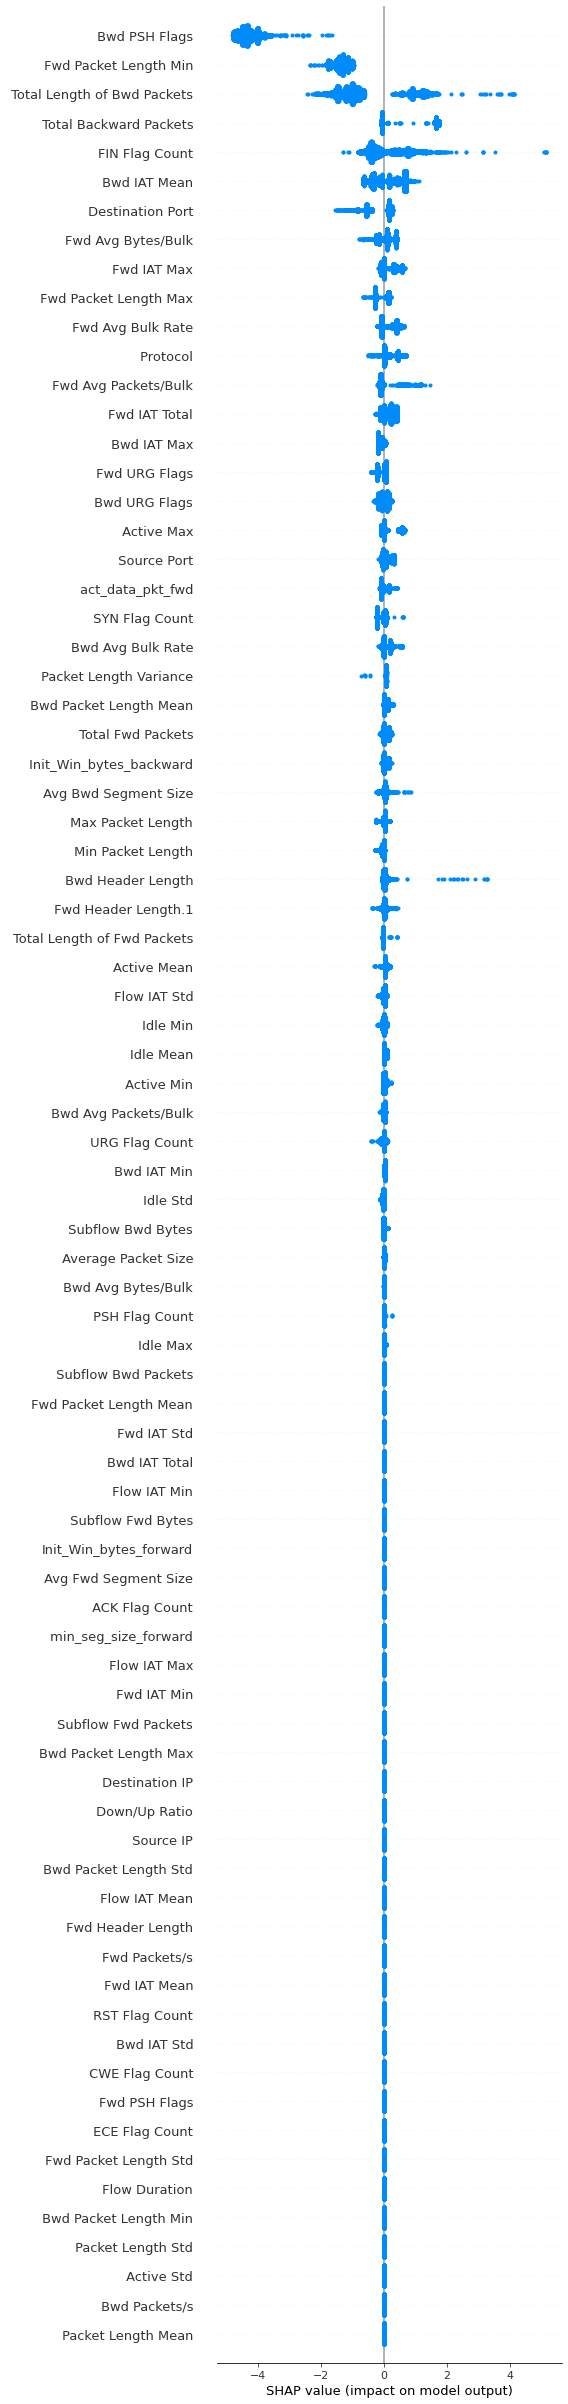

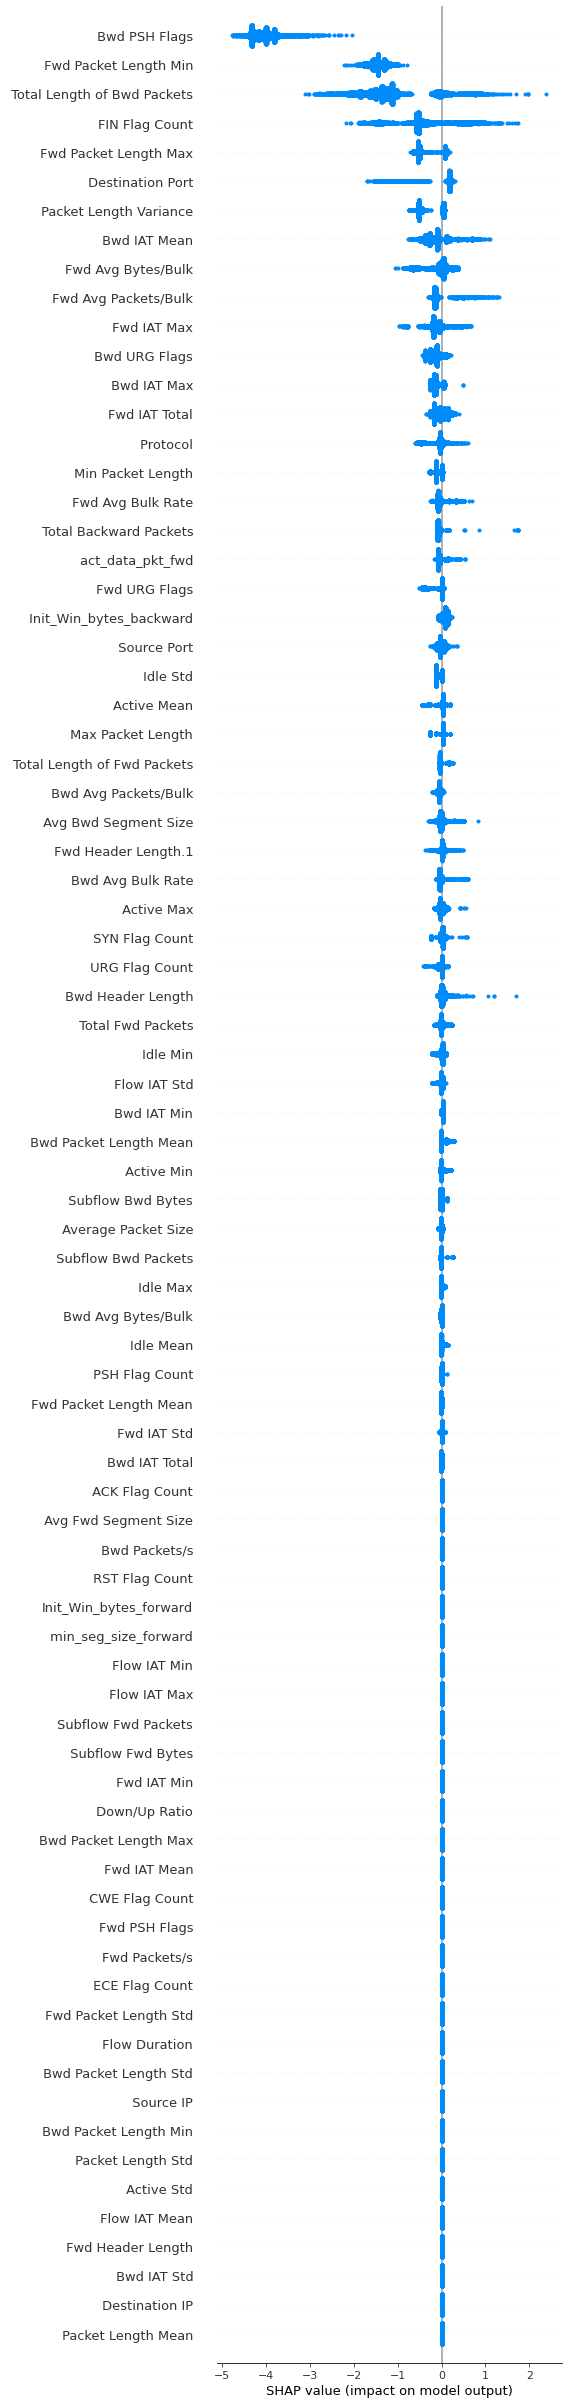

In [4]:
import pandas as pd
import shap
import pickle
import matplotlib.pyplot as plt
import numpy as np


X_test = pd.read_csv('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/Test_shap_xgb_Final.csv', encoding="ISO-8859–1", dtype = str)
X_test = X_test.apply(pd.to_numeric)
X_test = X_test.astype(float)


# print(X_test.dtypes.to_string())


# filename_expl = './src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/GNN_SHAP_explainer.sav'
filename_TreeExplainer = '/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/XGB_SHAP_shapvalues_TreeExplainer.sav'
filename_Explainer = '/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/XGB_SHAP_shapvalues_explainer.sav'
filename_PermExplainer = '/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/XGB_SHAP_shapvalues_explainer_perm.sav'

# load_explainer = pickle.load(open(filename_expl, 'rb'))
# print(load_explainer)

label_column = X_test["label"]
attack_indx = []
benign_indx = []
for i, x in enumerate(label_column):
    if (x == 1.0):
        attack_indx.append(i)
    elif (x == 0.0):
        benign_indx.append(i)

load_shap_values_tree = pickle.load(open(filename_TreeExplainer, 'rb'))
load_shap_values_expl = pickle.load(open(filename_Explainer, 'rb'))
load_shap_values_perm = pickle.load(open(filename_PermExplainer, 'rb'))

cols = list(set(list(X_test.columns )) - set(list(['label'])))
X_test = X_test[cols]

# TreeExplainer
print("TreeExplainer")
shap.summary_plot(load_shap_values_tree[attack_indx], feature_names = X_test.columns, max_display=X_test.shape[1])
shap.summary_plot(load_shap_values_tree[benign_indx], feature_names = X_test.columns, max_display=X_test.shape[1])

## With Default Explainer

Explainer


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


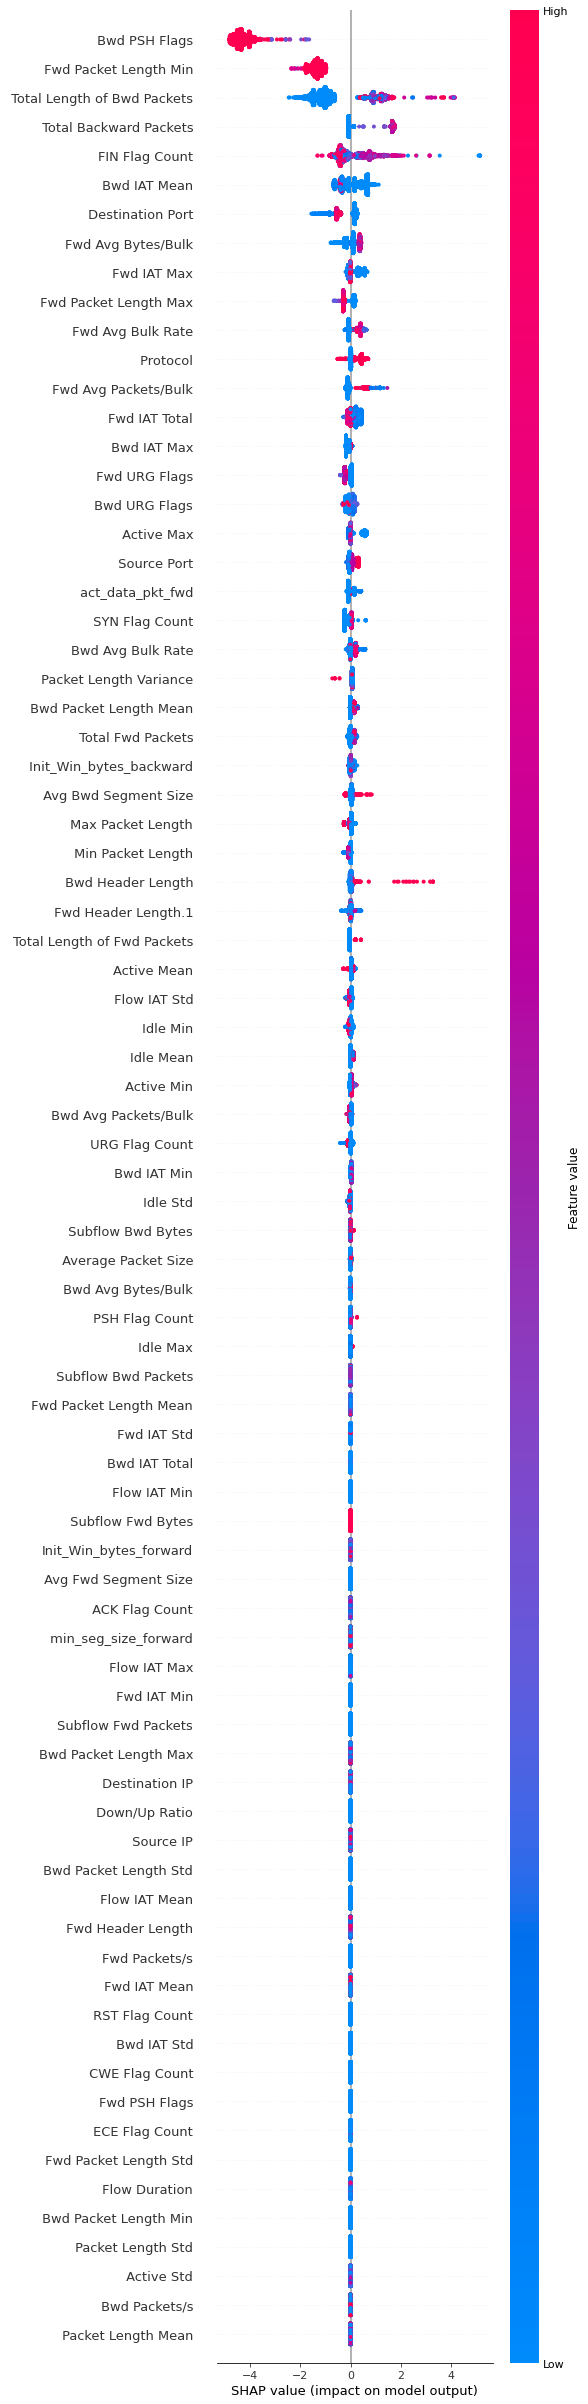

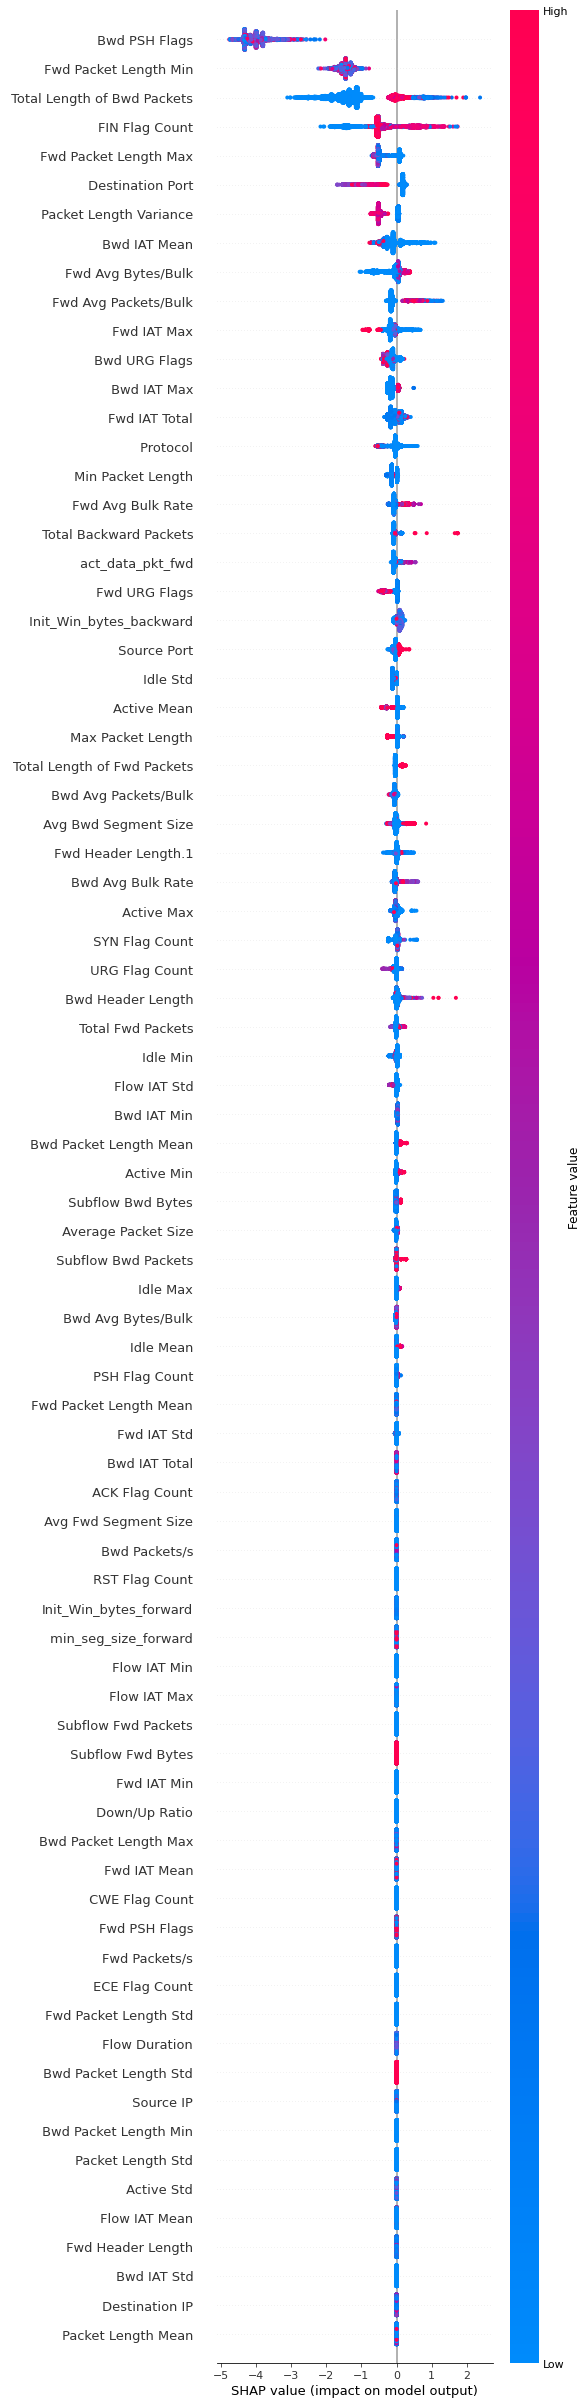

In [5]:
# Explainer
print("Explainer")
shap.summary_plot(load_shap_values_expl[attack_indx], feature_names = X_test.columns, max_display=X_test.shape[1])
shap.summary_plot(load_shap_values_expl[benign_indx], feature_names = X_test.columns, max_display=X_test.shape[1])

Permutation Explainer


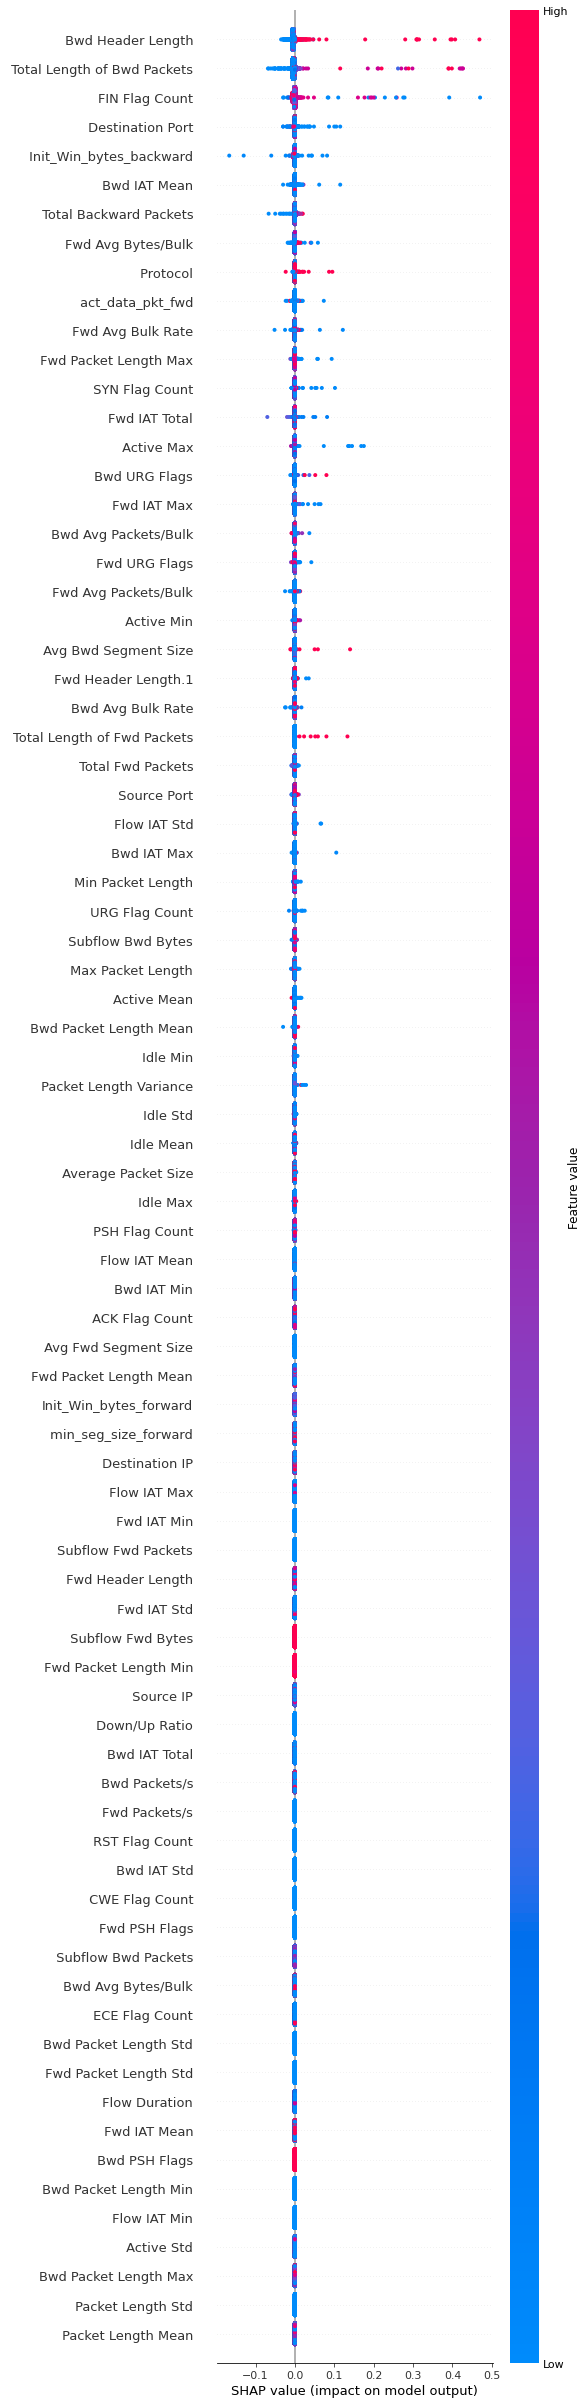

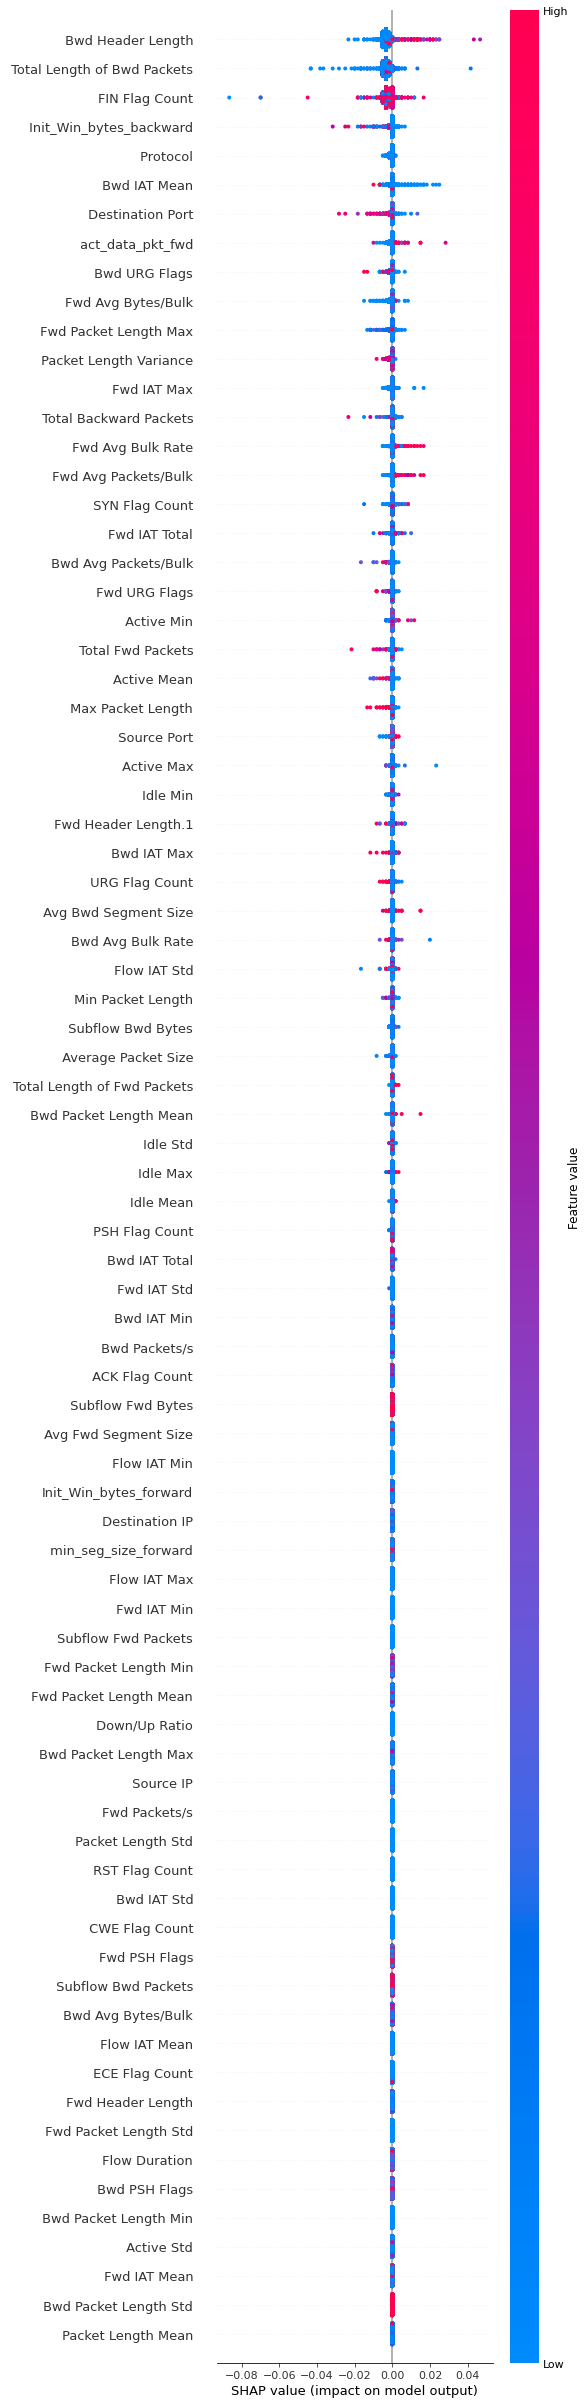

In [6]:
# Permutation Explainer
print("Permutation Explainer")
shap.summary_plot(load_shap_values_perm[attack_indx], feature_names = X_test.columns, max_display=X_test.shape[1])
shap.summary_plot(load_shap_values_perm[benign_indx], feature_names = X_test.columns, max_display=X_test.shape[1])